In [ ]:
%matplotlib inline  

In [32]:
import torch
import numpy as np
import math
import matplotlib.pylab as plt
import matplotlib as mpl

import os
import sys

In [ ]:
os.chdir("..")

In [ ]:
from optbnn.gp.models.gpr import GPR
from optbnn.gp import kernels, mean_functions
from optbnn.bnn.reparam_nets import MLPNormFlowsReparameterization
from optbnn.bnn.nets.mlp import MLP
from optbnn.bnn.likelihoods import LikGaussian
from optbnn.bnn.priors import FixedGaussianPrior, OptimNormFlowPrior
from optbnn.prior_mappers.wasserstein_mapper import MapperWasserstein, WassersteinDistance
from optbnn.utils.rand_generators import MeasureSetGenerator, GridGenerator
from optbnn.utils.normalization import normalize_data, zscore_normalization, zscore_unnormalization
from optbnn.metrics.sampling import compute_rhat_regression
from optbnn.utils import util
from optbnn.sgmcmc_bayes_net.regression_net import RegressionNet

In [33]:
mpl.rcParams['figure.dpi'] = 100

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [35]:
OUT_DIR = "./exp/1D_synthetic/tanh_nflow_new"
FIG_DIR = os.path.join(OUT_DIR, "figures")
util.ensure_dir(OUT_DIR)
util.ensure_dir(FIG_DIR)

In [36]:
SEED = 1
util.set_seed(SEED)

# Utilities

In [38]:
def make_random_gap(X, gap_ratio=0.2):
    a,b = X.min(),X.max()
    gap_a = a + np.random.rand() * (b-a)*(1-gap_ratio)
    gap_b = gap_a + (b-a)*gap_ratio
    idx = np.logical_and(gap_a<X, X<gap_b)
    if gap_a-a > b-gap_b:
        X[idx] = a + np.random.rand(idx.sum()) * (gap_a-a)
    else:
        X[idx] = gap_b + np.random.rand(idx.sum()) * (b-gap_b)

def gp_sample(X, ampl=1, leng=1, sn2=0.1):
    n, x = X.shape[0], X / leng
    sum_xx = np.sum(x*x, 1).reshape(-1, 1).repeat(n, 1)
    D = sum_xx + sum_xx.transpose() - 2 * np.matmul(x, x.transpose())
    C = ampl**2 * np.exp(-0.5 * D) + np.eye(n) * sn2
    return np.random.multivariate_normal(np.zeros(n), C).reshape(-1, 1)

def plot_samples(X, samples, var=None, n_keep=12, color="xkcd:bluish", smooth_q=False, ax=None):
    if ax is None: 
        ax = plt.gca()
    if samples.ndim > 2:
        samples = samples.squeeze()
    n_keep = int(samples.shape[1]/10) if n_keep is None else n_keep
    keep_idx = np.random.permutation(samples.shape[1])[:n_keep]
    mu = samples.mean(1)
    if var is None:
        q=97.72  ## corresponds to 2 stdevs in Gaussian
        # q = 99.99  ## corresponds to 3 std
        Q = np.percentile(samples, [100-q, q], axis=1)
        # ub, lb = Q[1,:], Q[0,:]
        ub, lb = mu + 2 * samples.std(1), mu - 2 * samples.std(1)
        if smooth_q:
            lb = moving_average(lb)
            ub = moving_average(ub)
    else:
        ub = mu + 3 * np.sqrt(var)
        lb = mu - 3 * np.sqrt(var)
    ####
    ax.fill_between(X.flatten(), ub, lb, color=color, alpha=0.25, lw=0)
    ax.plot(X, samples[:, keep_idx], color=color, alpha=0.8)
    ax.plot(X, mu, color='xkcd:red')

# Generate data

In [39]:
util.set_seed(1)

In [40]:
N = 64
M = 100
a, b = -10, 10

# Generate data
X = np.random.rand(N, 1) * (b-a) + a
make_random_gap(X, gap_ratio=0.4)
y = gp_sample(X, ampl=1.6, leng=1.8)
Xtest = np.linspace(a-5, b+5, M).reshape(-1, 1)

# Normalize the dataset
X_, X_mean, X_std = zscore_normalization(X)
y_, y_mean, y_std = zscore_normalization(y)
Xtest_, _, _ = zscore_normalization(Xtest, X_mean, X_std)

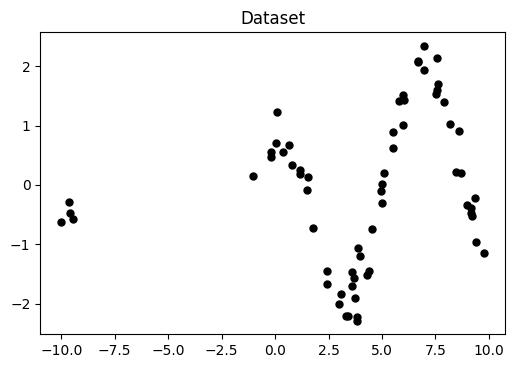

In [41]:
fig = plt.figure()
plt.plot(X, y, "ko", ms=5)
plt.title("Dataset")
plt.show()

In [42]:
Xtest_tensor = torch.from_numpy(Xtest_).to(device)

# Initialize Priors

In [43]:
# GP hyper-parameters
sn2 = 0.1
leng = 0.6
ampl = 1.0

# Initialize GP 
kernel = kernels.RBF(
        input_dim=1, ARD=True,
        lengthscales=torch.tensor([leng], dtype=torch.double),
        variance=torch.tensor([ampl], dtype=torch.double))

gpmodel = GPR(X=torch.from_numpy(X_).to(device),
              Y=torch.from_numpy(y_).reshape([-1, 1]).to(device),
              kern=kernel, mean_function=mean_functions.Zero())
gpmodel.likelihood.variance.set(sn2)
gpmodel = gpmodel.to(device)

In [48]:
# Initialize BNN Priors
width = 50
depth = 3
transfer_fn = "tanh"

std_bnn = MLPNormFlowsReparameterization(input_dim=1, output_dim=1, activation_fn=transfer_fn,
                                        hidden_dims=[width]*depth, n_transformations=4)

opt_bnn = MLPNormFlowsReparameterization(input_dim=1, output_dim=1, activation_fn=transfer_fn,
                                        hidden_dims=[width]*depth, n_transformations=4)

std_bnn = std_bnn.to(device)
opt_bnn = opt_bnn.to(device)

# Optimize Prior

In [49]:
data_generator = GridGenerator(-6, 6)

In [50]:
mapper_num_iters = 800

In [51]:
mapper = MapperWasserstein(gpmodel, opt_bnn, data_generator,
                            out_dir=OUT_DIR, 
                            wasserstein_steps=(0, 1000),
                            wasserstein_lr=0.08,
                            n_data=200, n_gpu=1, gpu_gp=True)
w_hist = mapper.optimize(num_iters=mapper_num_iters, n_samples=512, lr=0.01, 
                         save_ckpt_every=50, print_every=20, debug=True)
path = os.path.join(OUT_DIR, "wsr_values.log")
np.savetxt(path, w_hist, fmt='%.6e')        

>>> Iteration #   1: Wasserstein Dist 24.1596
>>> Iteration #  20: Wasserstein Dist 16.7979
>>> Iteration #  40: Wasserstein Dist 15.7570
>>> Iteration #  60: Wasserstein Dist 14.7440
>>> Iteration #  80: Wasserstein Dist 13.0554
>>> Iteration # 100: Wasserstein Dist 12.3433
>>> Iteration # 120: Wasserstein Dist 11.5079
>>> Iteration # 140: Wasserstein Dist 9.5502
>>> Iteration # 160: Wasserstein Dist 8.8282
>>> Iteration # 180: Wasserstein Dist 6.3650
>>> Iteration # 200: Wasserstein Dist 5.4651
>>> Iteration # 220: Wasserstein Dist 4.4485
>>> Iteration # 240: Wasserstein Dist 3.0345
>>> Iteration # 260: Wasserstein Dist 2.6889
>>> Iteration # 280: Wasserstein Dist 5.0516
>>> Iteration # 300: Wasserstein Dist 0.8643
>>> Iteration # 320: Wasserstein Dist 1.3422
>>> Iteration # 340: Wasserstein Dist 0.5052
>>> Iteration # 360: Wasserstein Dist 0.7206
>>> Iteration # 380: Wasserstein Dist 0.1965
>>> Iteration # 400: Wasserstein Dist 1.8720
>>> Iteration # 420: Wasserstein Dist 0.5876
>>>

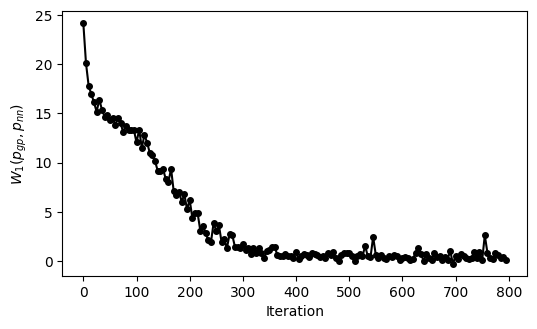

In [71]:
wdist_file = os.path.join(OUT_DIR, "wsr_values.log")
wdist_vals = np.loadtxt(wdist_file)

fig = plt.figure(figsize=(6, 3.5))
indices = np.arange(mapper_num_iters)[::5]
plt.plot(indices, wdist_vals[indices], "-ko", ms=4)
plt.ylabel(r"$W_1(p_{gp}, p_{nn})$")
plt.xlabel("Iteration")
plt.show()

# Visualize Prior

In [72]:
# Load the optimize prior
ckpt_path = os.path.join(OUT_DIR, "ckpts", "it-{}.ckpt".format(mapper_num_iters))
opt_bnn.load_state_dict(torch.load(ckpt_path))

<All keys matched successfully>

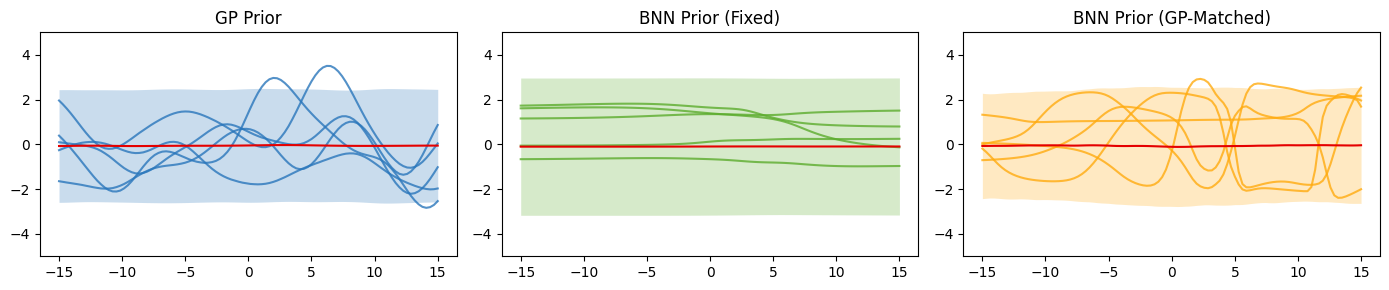

In [78]:
# Draw functions 
n_plot = 4000

gp_samples = gpmodel.sample_functions(
   Xtest_tensor, n_plot).detach().cpu().numpy().squeeze()
gp_samples = zscore_unnormalization(gp_samples, y_mean, y_std)

std_bnn_samples = std_bnn.sample_functions(
    Xtest_tensor.float(), n_plot).detach().cpu().numpy().squeeze()
std_bnn_samples = zscore_unnormalization(std_bnn_samples, y_mean, y_std)

opt_bnn_samples = opt_bnn.sample_functions(
    Xtest_tensor.float(), n_plot).detach().cpu().numpy().squeeze()
opt_bnn_samples = zscore_unnormalization(opt_bnn_samples, y_mean, y_std)


fig, axs = plt.subplots(1, 3, figsize=(14, 3))
plot_samples(Xtest, gp_samples, ax=axs[0], n_keep=5)
axs[0].set_title('GP Prior')
axs[0].set_ylim([-5, 5])

plot_samples(Xtest, std_bnn_samples, ax=axs[1], color='xkcd:grass', n_keep=5)
axs[1].set_title('BNN Prior (Fixed)')
axs[1].set_ylim([-5, 5])

plot_samples(Xtest, opt_bnn_samples, ax=axs[2], color='xkcd:yellowish orange', n_keep=5)
axs[2].set_title('BNN Prior (GP-Matched)')
axs[2].set_ylim([-5, 5])

plt.tight_layout()
plt.show()

# Posterior Inference



# GP


In [79]:
# Make predictions
gp_preds = gpmodel.predict_f_samples(Xtest_tensor, 1000)
gp_preds = gp_preds.detach().cpu().numpy().squeeze()
gp_preds = zscore_unnormalization(gp_preds, y_mean, y_std)

## BNN with Fixed Normalizing Flow Prior


In [16]:
# SGHMC Hyper-parameters
sampling_configs = {
    "batch_size": 32,
    "num_samples": 30,
    "n_discarded": 10,
    "num_burn_in_steps": 2000,
    "keep_every": 2000,
    "lr": 0.01,
    "num_chains": 4,
    "mdecay": 0.01,
    "print_every_n_samples": 5
}

In [26]:
# Initialize the prior
model = MLPNormFlowsReparameterization(input_dim=1, output_dim=1, activation_fn=transfer_fn,
                                       hidden_dims=[width]*depth, n_transformations=4)
model = model.to(device)
prior = OptimNormFlowPrior(model, saved_path=None, device=device)

# Setup likelihood
net = MLP(1, 1, [width]*depth, transfer_fn)
likelihood = LikGaussian(sn2)

# Initialize the sampler
saved_dir = os.path.join(OUT_DIR, "sampling_std")
util.ensure_dir(saved_dir)
bayes_net_std = RegressionNet(net, likelihood, prior, saved_dir, n_gpu=0)

# Start sampling
bayes_net_std.sample_multi_chains(X, y, **sampling_configs)

Chain: 0
Samples #     5 : NLL =  4.4865e-01 RMSE = 3.7049e-01 
Samples #    10 : NLL =  3.9741e-01 RMSE = 3.4498e-01 
Samples #    15 : NLL =  4.0328e-01 RMSE = 3.4797e-01 
Samples #    20 : NLL =  3.8725e-01 RMSE = 3.4183e-01 
Chain: 1
Samples #    25 : NLL =  3.8439e-01 RMSE = 3.4050e-01 
Samples #    30 : NLL =  4.0021e-01 RMSE = 3.4796e-01 
Samples #    35 : NLL =  4.0550e-01 RMSE = 3.5107e-01 
Samples #    40 : NLL =  4.0264e-01 RMSE = 3.4951e-01 
Chain: 2
Samples #    45 : NLL =  4.0400e-01 RMSE = 3.5053e-01 
Samples #    50 : NLL =  4.0034e-01 RMSE = 3.4878e-01 
Samples #    55 : NLL =  4.0268e-01 RMSE = 3.5014e-01 
Samples #    60 : NLL =  4.0531e-01 RMSE = 3.5155e-01 
Chain: 3
Samples #    65 : NLL =  4.0736e-01 RMSE = 3.5251e-01 
Samples #    70 : NLL =  4.0696e-01 RMSE = 3.5228e-01 
Samples #    75 : NLL =  4.0920e-01 RMSE = 3.5343e-01 
Samples #    80 : NLL =  4.0706e-01 RMSE = 3.5231e-01 


In [27]:
# Make predictions
_, _, bnn_std_preds = bayes_net_std.predict(Xtest, True)
r_hat = compute_rhat_regression(bnn_std_preds, sampling_configs["num_chains"])
print(r"R-hat: mean {:.4f} std {:.4f}".format(float(r_hat.mean()), float(r_hat.std())))
bnn_std_preds = bnn_std_preds.squeeze().T

posterior_std_path = os.path.join(OUT_DIR, "posterior_std.npz")
np.savez(posterior_std_path, bnn_samples=bnn_std_preds)

R-hat: mean 1.0244 std 0.0365


## BNN with Optimized Normalizing Flow Prior



In [66]:
# Setup likelihood
net = MLP(1, 1, [width]*depth, transfer_fn)
likelihood = LikGaussian(sn2)

# Load the optimized prior
ckpt_path = os.path.join(OUT_DIR, "ckpts", "it-{}.ckpt".format(800))
model = MLPNormFlowsReparameterization(input_dim=1, output_dim=1, activation_fn=transfer_fn,
                                       hidden_dims=[width]*depth, n_transformations=4)
model = model.to(device)
prior = OptimNormFlowPrior(model, ckpt_path, device)

# Initialize the sampler
saved_dir = os.path.join(OUT_DIR, "sampling_optim")
util.ensure_dir(saved_dir)
bayes_net_optim = RegressionNet(net, likelihood, prior, saved_dir, n_gpu=1)

# Start sampling
bayes_net_optim.sample_multi_chains(X, y, **sampling_configs)

Chain: 0
Samples #     5 : NLL =  2.7505e-01 RMSE = 2.7075e-01 
Samples #    10 : NLL =  2.6241e-01 RMSE = 2.6524e-01 
Samples #    15 : NLL =  2.5551e-01 RMSE = 2.6147e-01 
Samples #    20 : NLL =  2.5200e-01 RMSE = 2.5647e-01 
Chain: 1
Samples #    25 : NLL =  2.5425e-01 RMSE = 2.5642e-01 
Samples #    30 : NLL =  2.5590e-01 RMSE = 2.5601e-01 
Samples #    35 : NLL =  2.6095e-01 RMSE = 2.5715e-01 
Samples #    40 : NLL =  2.6118e-01 RMSE = 2.5692e-01 
Chain: 2
Samples #    45 : NLL =  2.6942e-01 RMSE = 2.5971e-01 
Samples #    50 : NLL =  2.8016e-01 RMSE = 2.6142e-01 
Samples #    55 : NLL =  2.7800e-01 RMSE = 2.6192e-01 
Samples #    60 : NLL =  2.7605e-01 RMSE = 2.6161e-01 
Chain: 3
Samples #    65 : NLL =  2.7359e-01 RMSE = 2.6099e-01 
Samples #    70 : NLL =  2.7284e-01 RMSE = 2.6136e-01 
Samples #    75 : NLL =  2.7357e-01 RMSE = 2.6178e-01 
Samples #    80 : NLL =  2.7302e-01 RMSE = 2.6146e-01 


In [67]:
# Make predictions
_, _, bnn_optim_preds = bayes_net_optim.predict(Xtest, True)
r_hat = compute_rhat_regression(bnn_optim_preds, sampling_configs["num_chains"])
print(r"R-hat: mean {:.4f} std {:.4f}".format(float(r_hat.mean()), float(r_hat.std())))
bnn_optim_preds = bnn_optim_preds.squeeze().T

posterior_optim_path = os.path.join(OUT_DIR, "posterior_optim.npz")
np.savez(posterior_optim_path, bnn_samples=bnn_optim_preds)

R-hat: mean 1.0411 std 0.0601


# Visualize Predictive Posterior

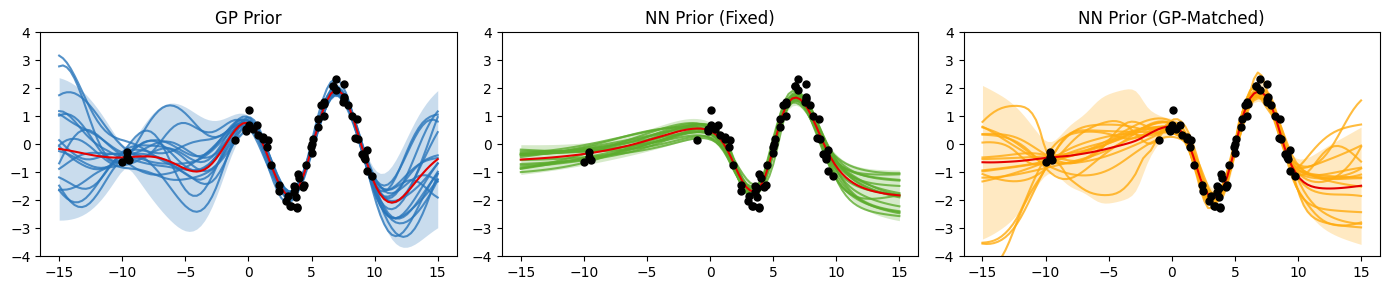

In [91]:
fig, axs = plt.subplots(1, 3, figsize=(14, 3))

plot_samples(Xtest, gp_preds, ax=axs[0], n_keep=16)
axs[0].plot(X, y, 'ok', zorder=10, ms=5)
axs[0].set_title('GP Prior')
axs[0].set_ylim([-4, 4])

plot_samples(Xtest, bnn_std_preds, ax=axs[1], color='xkcd:grass', n_keep=16)
axs[1].plot(X, y, 'ok', zorder=10, ms=5)
axs[1].set_title('NN Prior (Fixed)')
axs[1].set_ylim([-4, 4])

plot_samples(Xtest, bnn_optim_preds, ax=axs[2], color='xkcd:yellowish orange', n_keep=16)
axs[2].plot(X, y, 'ok', zorder=10, ms=5)
axs[2].set_title('NN Prior (GP-Matched)')
axs[2].set_ylim([-4, 4])

plt.tight_layout()
plt.show()